In [1]:
import os, time, sys
from pathlib import Path
import sqlite3
import cv2
import numpy as np
from matplotlib import pyplot as plt

ROOT = Path().absolute().parent
GROUND_TRUTH_PATH = Path(f"{ROOT}/datasets/DS2_Bode_Museum_Raw")
COMPARISON_PATHS = [
    Path(f"{ROOT}/data/3_results/DS5_Bode_Museum_Filter3")
]
GROUND_TRUTH_DB_PATH = f"{GROUND_TRUTH_PATH}/database.db"

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

COLMAP_PY_SCRIPTS_PATH = f"{ROOT}/third_party/colmap/scripts/python"
if COLMAP_PY_SCRIPTS_PATH not in sys.path:
    sys.path.append(COLMAP_PY_SCRIPTS_PATH)

In [2]:
'''
scr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_matches.py"
OUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_matches.txt"
! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --output_path "{OUT_PATH}" --min_num_matches 15

scr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_pairs.py"
OUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_pairs.txt"
! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --match_list_path "{OUT_PATH}" --min_num_matches 15

# Alternative Way of Loading Model Data!:
from read_write_model import read_model, qvec2rotmat
'''

'\nscr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_matches.py"\nOUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_matches.txt"\n! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --output_path "{OUT_PATH}" --min_num_matches 15\n\nscr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_pairs.py"\nOUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_pairs.txt"\n! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --match_list_path "{OUT_PATH}" --min_num_matches 15\n\n# Alternative Way of Loading Model Data!:\nfrom read_write_model import read_model, qvec2rotmat\n'

In [3]:
# init Colmap db reader functions from https://github.com/colmap/colmap/blob/main/scripts/python/database.py#L412
MAX_IMAGE_ID = 2 ** 31 - 1

# Note that COLMAP supports:
#      - 2D keypoints: (x, y)
#      - 4D keypoints: (x, y, theta, scale)
#      - 6D affine keypoints: (x, y, a_11, a_12, a_21, a_22)
# in the db each table has rows and columns! rows = number of entries, columns = format of entry (2D, 4D, 6D)
# e.g.: 1800 rows and 4 cols = 1800 entries of type 4D (x, y, theta, scale)

def get_image(cursor, img_id, path):
    cursor.execute(f"SELECT i.name, c.width, c.height FROM images as i, cameras as c WHERE c.camera_id = i.camera_id AND i.image_id = {img_id}")
    image_data = cursor.fetchone()
    image_name, width, height = image_data
    return cv2.imread(f"{path}/images_raw/{image_name}")

def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % MAX_IMAGE_ID
    image_id1 = (pair_id - image_id2) / MAX_IMAGE_ID
    return image_id1, image_id2

def get_keypoints(cursor, img_id):
    dtype=np.float32
    #keypoints = dict(
    #    (image_id, np.frombuffer(data, dtype=dtype).reshape(*shape) )
    #    for image_id, data in cursor.execute(f"SELECT image_id, data FROM keypoints WHERE image_id={image_id}")
    #)
    keypoints = []
    result = cursor.execute(f"SELECT image_id, rows, cols, data FROM keypoints WHERE image_id={img_id}")
    for image_id, rows, cols, data in result:
        if not data: continue
        shape=(-1, cols)
        coordinates = np.frombuffer(data, dtype=dtype).reshape(*shape)
        keypoints.append({
            "image_id": int(image_id),
            "coordinates": coordinates
        })
    return keypoints

# Get all matches
def get_matches(cursor, img_ids_filter = None):
    dtype=np.uint32
    matches = []
    for pair_id, rows, cols, data in cursor.execute("SELECT pair_id, rows, cols, data FROM matches"):
        if not data: continue
        image1, image2 = pair_id_to_image_ids(pair_id)
        image1 = int(image1)
        image2 = int(image2)

        if img_ids_filter:
            assert len(img_ids_filter) > 0
            assert len(img_ids_filter) <= 2

            if len(img_ids_filter) == 1:
                # sufficient if any of both is contained
                if image1 not in img_ids_filter and image2 not in img_ids_filter:
                    continue
            else:
                # both have to be in selection!
                if not (image1 in img_ids_filter and image2 in img_ids_filter):
                    continue
        
        shape=(-1, cols)
        image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
        matches.append({
            "pair_id": pair_id,
            "image1_id": int(image1),
            "image2_id": int(image2),
            "image_matches": image_matches
        })
    return matches

# Get the matches that are of good enough quality
def get_inlier_matches(cursor, img_ids_filter = None):
    dtype=np.uint32
    matches = []
    for pair_id, rows, cols, data in cursor.execute("SELECT pair_id, rows, cols, data FROM two_view_geometries"):
        if not data: continue
        image1, image2 = pair_id_to_image_ids(pair_id)
        image1 = int(image1)
        image2 = int(image2)

        if img_ids_filter:
            assert len(img_ids_filter) > 0
            assert len(img_ids_filter) <= 2

            if len(img_ids_filter) == 1:
                # sufficient if any of both is contained
                if image1 not in img_ids_filter and image2 not in img_ids_filter:
                    continue
            else:
                # both have to be in selection!
                if not (image1 in img_ids_filter and image2 in img_ids_filter):
                    continue
        
        shape=(-1, cols)
        image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
        matches.append({
            "pair_id": pair_id,
            "image1_id": int(image1),
            "image2_id": int(image2),
            "image_matches": image_matches
        })
    return matches

# Get the matches that are of not good enough quality
def get_outlier_matches(cursor, img_ids_filter = None):
    all_matches = get_matches(cursor, img_ids_filter)
    inlier_matches = get_inlier_matches(cursor, img_ids_filter)
    outlier_matches = []
    for am in all_matches:
        am_clone = dict(am)
        am_clone["image_matches"] = []
        for amm in am["image_matches"]:
            if any((m == amm).all() for m in inlier_matches[0]["image_matches"]):
                continue
            am_clone["image_matches"].append(amm)
        outlier_matches.append(am_clone)
    return outlier_matches

# matches is a dict!! only one object
def get_matches_coords(cursor, matches):
    ret = []
    skipped_kps = []
    
    img1_kps = get_keypoints(cursor, matches["image1_id"])[0]
    img2_kps = get_keypoints(cursor, matches["image2_id"])[0]
    
    new_matches = dict(matches) # copy instance
    new_matches["image_matches"] = [] # clear old matches to be replaced by coords
    for im_m in matches["image_matches"]:
        img1_kp_index = im_m[0]
        img2_kp_index = im_m[1]
        img1_kp_coords = img1_kps["coordinates"]
        img2_kp_coords = img2_kps["coordinates"]
        img1_kp_coords_len = img1_kp_coords.shape[0]
        img2_kp_coords_len = img2_kp_coords.shape[0]
        
        if img1_kp_index >= img1_kp_coords_len or img2_kp_index >= img2_kp_coords_len:
            skipped_kps.append((img1_kp_index, img2_kp_index))
            continue

        im_m_coords = [
            img1_kp_coords[img1_kp_index],
            img2_kp_coords[img2_kp_index]
        ]
        new_matches["image_matches"].append(im_m_coords)

    if len(skipped_kps) != 0: print(f"skipped matches: {skipped_kps}")
    return new_matches

In [4]:
conn = sqlite3.connect(GROUND_TRUTH_DB_PATH)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('cameras',), ('sqlite_sequence',), ('images',), ('keypoints',), ('descriptors',), ('matches',), ('two_view_geometries',)]


In [5]:
# Collect /Aggregate Useful Info
from tabulate import tabulate
from colorama import  Back, Style, Fore
import statistics

def get_kp_per_image(cursor):
    table = []
    for image_id, name, camera_id, kp_amount, in cursor.execute("SELECT i.image_id, i.name, i.camera_id, k.rows FROM images i, keypoints k WHERE i.image_id=k.image_id"):
        #print(f"{i}\tImg #{image_id} ({name}) with camera ID {camera_id}: {kp_amount} Keypoints")
        table.append([
            f"Img #{image_id} ({name})",
            camera_id,
            kp_amount
        ])
    #return tabulate(table, headers=['Img', 'Cam ID', 'Keypoints'], tablefmt='plain', showindex="always")
    return (table, ['Img', 'Cam ID', 'Keypoints'])

def get_matches_per_image_pairs(cursor, im_max = None, im_min = None, im_med = None):
    table = []
    for i, md in enumerate(get_matches(cursor)):
        #print(f"{i}\tImg Pairs {md['image1_id']}/{md['image2_id']}: {md['image_matches'].shape[0]} Feature Matches")
        # locate number of inlier matches for image pair
        #inlier_matches = filter(lambda x: (md['pair_id'] == x['pair_id']), inlier_matches)
        #inlier_matches = inlier_match[0]['image_matches'].shape[0] if len(inlier_match) > 0 else None
        rows, = cursor.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={md['pair_id']}")
        matches = md['image_matches'].shape[0]
        matches_ratio = int(round((rows[0]/matches) * 100, 0))
        if matches_ratio == 0:
            matches_ratio_color = Back.LIGHTRED_EX
        elif matches_ratio < 50:
            matches_ratio_color = Back.RED
        elif matches_ratio < 75:
            matches_ratio_color = Back.YELLOW
        elif matches_ratio < 90:
            matches_ratio_color = Back.GREEN
        else:
            matches_ratio_color = Back.LIGHTGREEN_EX

        inlier_matches = int(rows[0])
        if im_max and int(im_max) == inlier_matches:
            im_matches_color = Back.GREEN
        elif im_min and int(im_min) == inlier_matches:
            im_matches_color = Back.RED
        elif im_med and int(im_med) == inlier_matches:
            im_matches_color = Back.BLUE
        else: im_matches_color = ""

        table.append([
            f"{Back.BLACK if md['image1_id']%2 == 0 else Back.LIGHTBLACK_EX}{md['image1_id']} / {md['image2_id']}{Style.RESET_ALL}",
            matches,
            f"{im_matches_color}{inlier_matches}{Style.RESET_ALL}",
            f"{matches_ratio_color}{matches_ratio}%{Style.RESET_ALL}"
        ])
    # returns tuple(table_body, table_headers)
    return (table, ['Img Pair', 'Feature Matches', 'Inlier Matches', 'Ratio'])

def get_inlier_matches_per_image_median(cursor):
    #inlier_matches = get_inlier_matches(cursor)
    #inlier_matches = [im['image_matches'].shape[0] for im in inlier_matches]
    inlier_matches = cursor.execute("SELECT rows FROM two_view_geometries")
    inlier_matches = [im[0] for im in cursor.fetchall()]
    return statistics.median(inlier_matches)


def run_sfm_analysis(cursor):
    cursor.execute("SELECT SUM(rows) FROM keypoints")
    total_keypoints, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM images")
    total_images, = cursor.fetchall()[0]
    avg_kp_per_image = round(total_keypoints/total_images, 2)
    cursor.execute("SELECT MIN(rows) FROM keypoints")
    min_keypoints, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM keypoints")
    max_keypoints, = cursor.fetchall()[0]
    
    cursor.execute("SELECT SUM(rows) FROM matches")
    total_match_amount, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM matches")
    total_image_pair_matches, = cursor.fetchall()[0]
    avg_matches_per_image_pair = round(total_match_amount/total_image_pair_matches, 2)
    cursor.execute("SELECT MIN(rows) FROM matches")
    min_matches, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM matches")
    max_matches, = cursor.fetchall()[0]
    
    cursor.execute("SELECT SUM(rows) FROM two_view_geometries")
    total_inlier_match_amount, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM two_view_geometries")
    total_image_pair_inlier_matches, = cursor.fetchall()[0]
    avg_inlier_matches_per_image_pair = round(total_inlier_match_amount/total_image_pair_inlier_matches, 2)
    cursor.execute("SELECT MIN(rows) FROM two_view_geometries")
    min_inlier_matches, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM two_view_geometries")
    max_inlier_matches, = cursor.fetchall()[0]
    imm_p_im = get_inlier_matches_per_image_median(cursor)
    
    return {
        "images": {
            "sum": total_images
        },
        "keypoints": {
            "min": min_keypoints,
            "max": max_keypoints,
            "avg": avg_kp_per_image,
            "sum": total_keypoints
        },
        "matches": {
            "min": min_matches,
            "max": max_matches,
            "avg": avg_matches_per_image_pair,
            "sum": total_match_amount
        },
        "inlier_matches": {
            "min": min_inlier_matches,
            "max": max_inlier_matches,
            "avg": avg_inlier_matches_per_image_pair,
            "med": imm_p_im,
            "sum": total_inlier_match_amount,
        },
        "keypoints_table": get_kp_per_image(cursor),
        "matches_table": get_matches_per_image_pairs(cursor, im_max=max_inlier_matches, im_min=min_inlier_matches, im_med=imm_p_im)
    }

def pprint_sfm_analysis(analysis_result):
    print(f"Total Features Found: {analysis_result['keypoints']['sum']}")
    print(f"Total Images: {analysis_result['images']['sum']}")
    print(f"Avg. Features/Image: {analysis_result['keypoints']['avg']}")
    print(f"Lowest Features/Image: {analysis_result['keypoints']['min']}")
    print(f"Highest Features/Image: {analysis_result['keypoints']['max']}")
    print("\n")
    print(f"Total Feature Matches: {analysis_result['matches']['sum']}")
    #print(f"Total Image Pair Feature Matches: {total_image_pair_matches}")
    print(f"Avg. Feature Matches/Image Pair: {analysis_result['matches']['avg']}")
    print(f"Lowest Feature Matches/Image Pair: {analysis_result['matches']['min']}")
    print(f"Highest Feature Matches/Image Pair: {analysis_result['matches']['max']}")
    print("\n")
    print(f"Total Inlier Feature Matches: {analysis_result['inlier_matches']['sum']}")
    #print(f"Avg. Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['avg']}")
    # Median, because we might have a lot of outliers which might affect the result!
    print(f"Median for Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['med']}")
    print(f"Lowest Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['min']}")
    print(f"Highest Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['max']}")
    print("\n")
    
    print("Images: ")
    print(
        tabulate(*(analysis_result['keypoints_table']), tablefmt='plain', showindex="always")
    )
    print("\n")
    
    print("Feature Matches: ")
    print(
        tabulate(*(analysis_result['matches_table']), tablefmt='plain', showindex="always")
    )
    return
    

analysis_result = run_sfm_analysis(cursor)
pprint_sfm_analysis(analysis_result)

Total Features Found: 336318
Total Images: 27
Avg. Features/Image: 12456.22
Lowest Features/Image: 10128
Highest Features/Image: 15547


Total Feature Matches: 136553
Avg. Feature Matches/Image Pair: 653.36
Lowest Feature Matches/Image Pair: 20
Highest Feature Matches/Image Pair: 4328


Total Inlier Feature Matches: 127164
Median for Feature Inlier Matches/Image Pair: 345
Lowest Feature Inlier Matches/Image Pair: 0
Highest Feature Inlier Matches/Image Pair: 4226


Images: 
    Img                        Cam ID    Keypoints
 0  Img #1 (IMG_0712.JPEG)          1        10147
 1  Img #2 (IMG_0713.JPEG)          1        10726
 2  Img #3 (IMG_0714.JPEG)          1        11291
 3  Img #4 (IMG_0715.JPEG)          1        10968
 4  Img #5 (IMG_0716.JPEG)          1        10582
 5  Img #6 (IMG_0717.JPEG)          1        10974
 6  Img #7 (IMG_0718.JPEG)          1        15092
 7  Img #8 (IMG_0719.JPEG)          1        15399
 8  Img #9 (IMG_0720.JPEG)          1        14477
 9  Img #10 

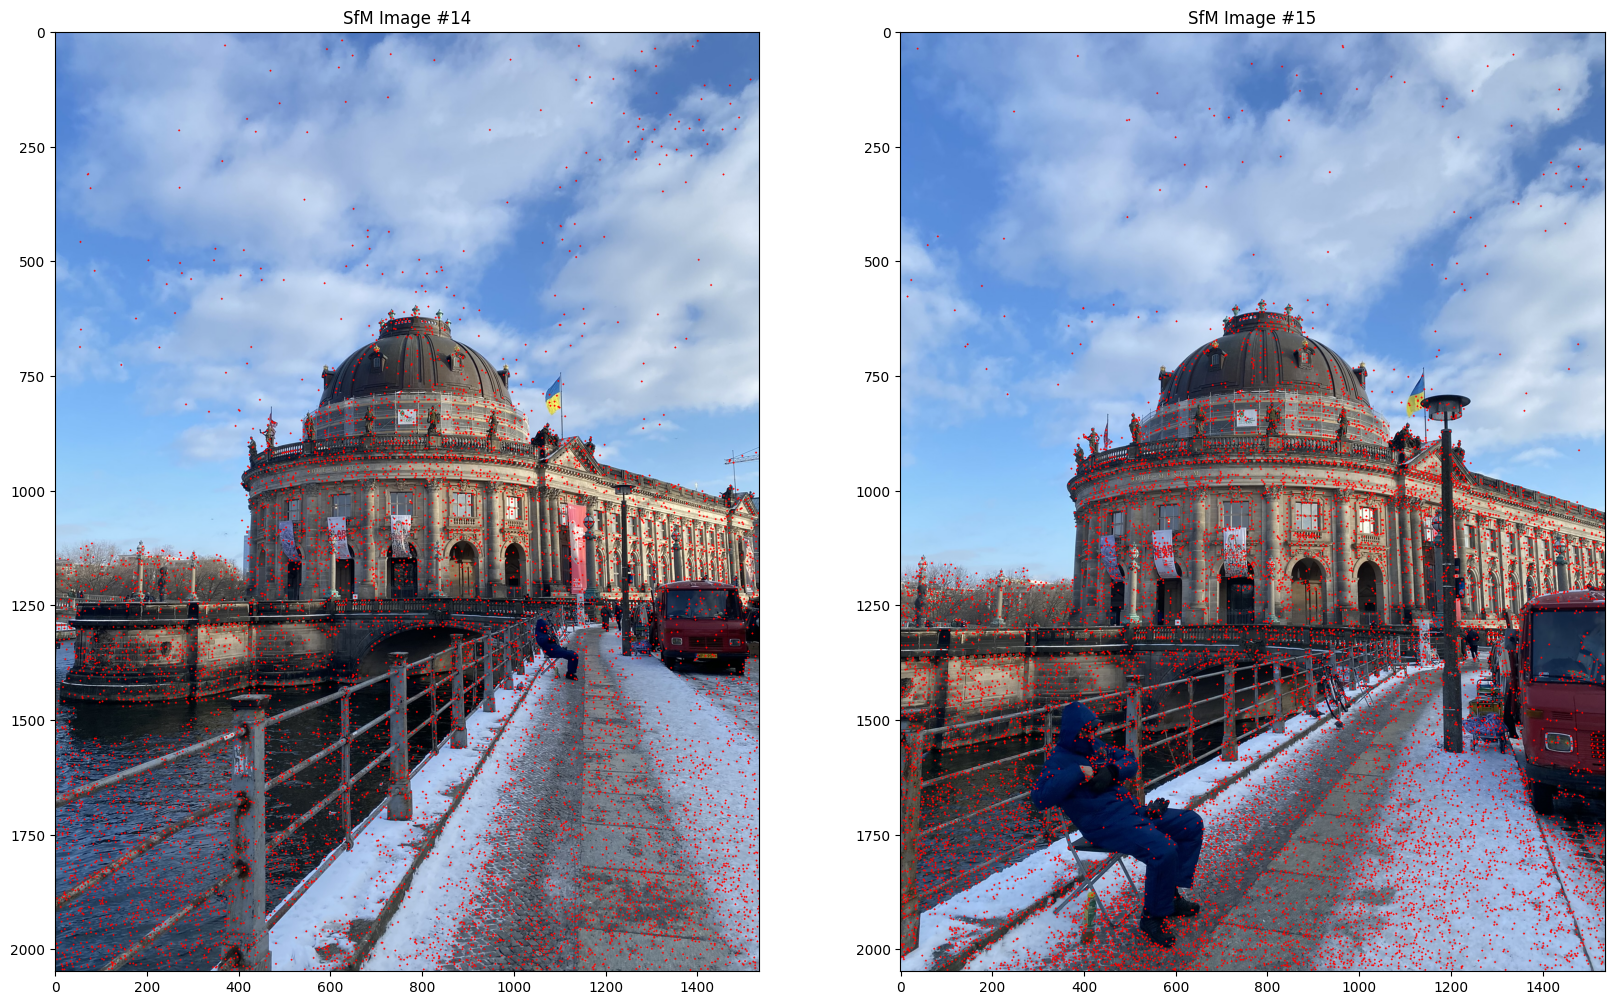

In [106]:
# Display Features for 2 Separate Images
image1_id = 14
image2_id = 15

# Get the image name and features for the given image ID
image1 = get_image(cursor, image1_id, GROUND_TRUTH_PATH)
image2 = get_image(cursor, image2_id, GROUND_TRUTH_PATH)

keypoints1 = get_keypoints(cursor, image1_id)[0]
for i, kpc in enumerate(keypoints1["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(image1, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

keypoints2 = get_keypoints(cursor, image2_id)[0]
for i, kpc in enumerate(keypoints2["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(image2, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

RGB_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
RGB_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
fig, axarr = plt.subplots(1,2)
#plt.imshow(RGB_img)
axarr[0].imshow(RGB_img1)
axarr[0].set_title(f"SfM Image #{image1_id}")
axarr[1].imshow(RGB_img2)
axarr[1].set_title(f"SfM Image #{image2_id}")

plt.show()

# Show the image with features
#cv2.imshow("Image with Features", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

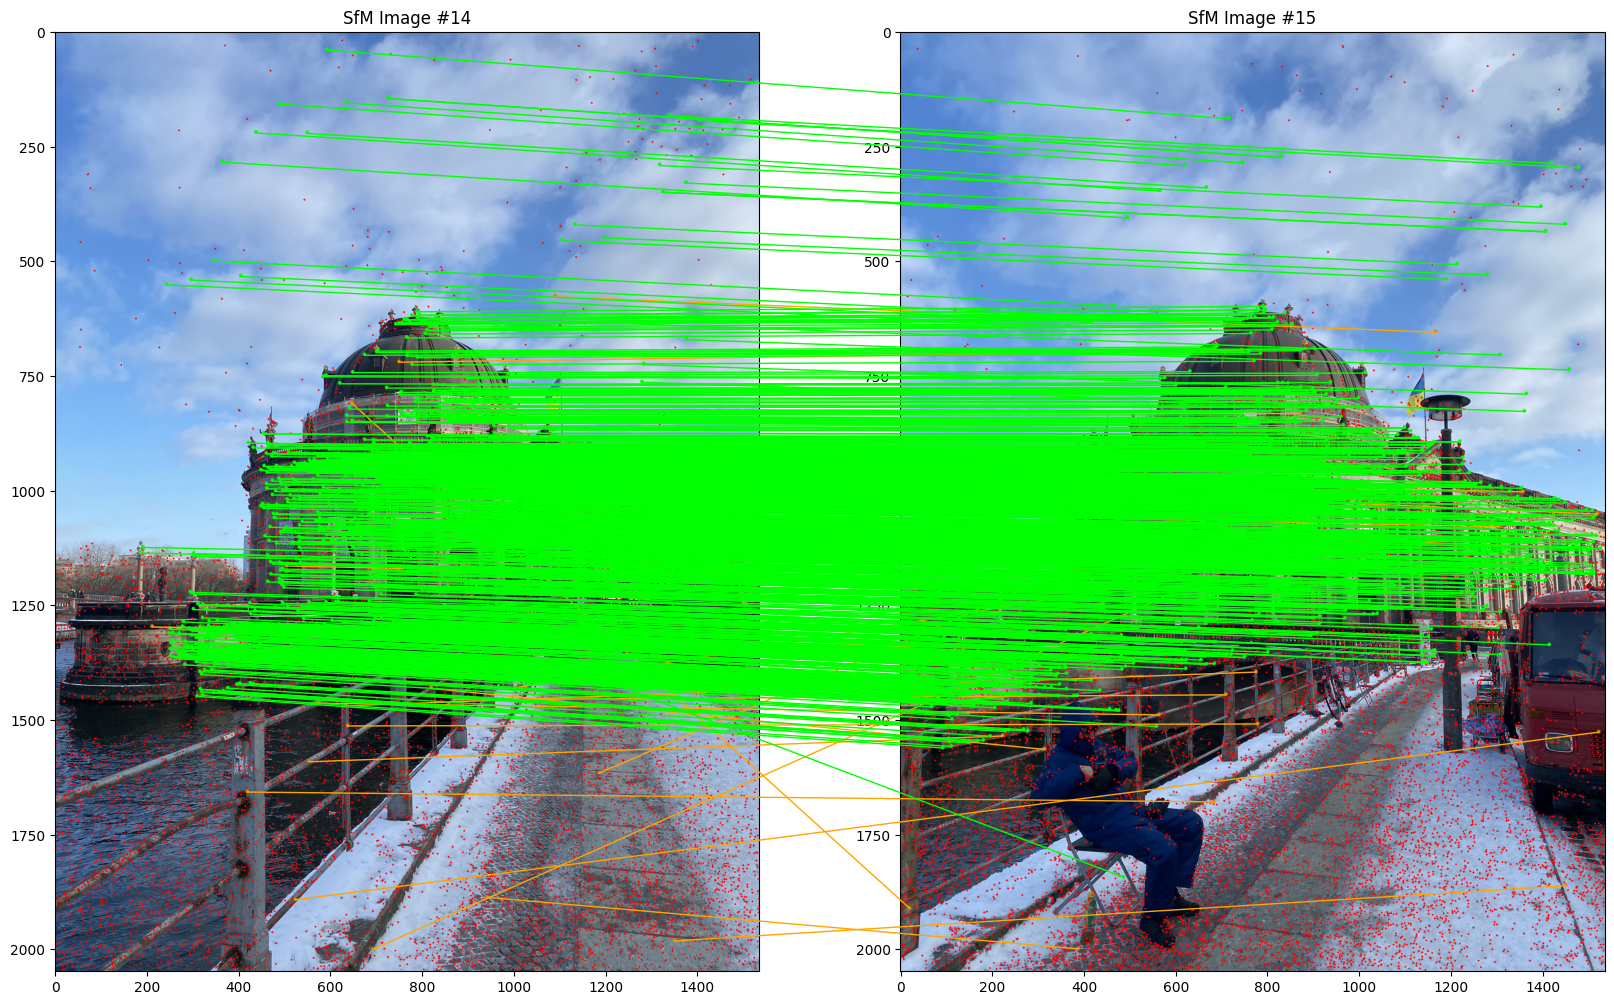

In [107]:
# Display Matched Features on Top (with option of connecting lines between features in images)
from matplotlib.patches import ConnectionPatch

DISPLAY_CONNECT_LINES = True

outlier_matches = get_outlier_matches(cursor, [image1_id, image2_id])
inlier_matches = get_inlier_matches(cursor, [image1_id, image2_id])
if len(outlier_matches) == 0:
    raise Exception("No shared feature matches between both images!")

outlier_matches_coords = get_matches_coords(cursor, outlier_matches[0])
inlier_matches_coords = get_matches_coords(cursor, inlier_matches[0])

def draw_points(matches, color, image1, image2):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        radius = 4
        cv2.circle(image1, (int(kpc1_x), int(kpc1_y)), radius=radius, color=color, thickness=-1)
        cv2.circle(image2, (int(kpc2_x), int(kpc2_y)), radius=radius, color=color, thickness=-1)
    return

def draw_lines(matches, color, plt_array, figure):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        
        # Create a connection patch between the two subplots
        con = ConnectionPatch(xyA=(kpc1_x, kpc1_y), xyB=(kpc2_x, kpc2_y),
                                coordsA="data", coordsB="data",
                                axesA=plt_array[0], axesB=plt_array[1], color=color)
        # Add the connection patch to the figure, not the axes
        figure.add_artist(con)
    return

draw_points(outlier_matches_coords["image_matches"], (0,  133,  219), image1, image2)
draw_points(inlier_matches_coords["image_matches"], (0,  255,  0), image1, image2)

RGB_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
RGB_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
fig, axarr = plt.subplots(1,2)
#plt.imshow(RGB_img)
axarr[0].imshow(RGB_img1)
axarr[0].set_title(f"SfM Image #{image1_id}")
#axarr[0].axis('off')
axarr[1].imshow(RGB_img2)
axarr[1].set_title(f"SfM Image #{image2_id}")
#axarr[1].axis('off')

# Loop through each keypoint pair and draw lines
if DISPLAY_CONNECT_LINES:
    draw_lines(outlier_matches_coords["image_matches"], "orange", axarr, fig)
    draw_lines(inlier_matches_coords["image_matches"], "lime", axarr, fig)

plt.show()

In [108]:
# Comparison Tool
# images in both reconstructions are the same (visually they can be different), so they can be compared directly one by one image
DIRECT_COMPARISON = True

comparison_path = COMPARISON_PATHS[0]
comparison_conn = sqlite3.connect(f"{comparison_path}/database.db")
comparison_cursor = comparison_conn.cursor()

import json
import math

def euclidean_distance(pos1, pos2):
    # Calculate the squared differences for each dimension
    squared_diffs = [(pos1[i] - pos2[i]) ** 2 for i in range(3)]
    # Sum the squared differences and take the square root
    distance = math.sqrt(sum(squared_diffs))
    return distance

def extract_position(transform_matrix):
    # Extract the position from the last column of the matrix
    position = [transform_matrix[i][3] for i in range(3)]
    return position

def compare_pose_estimation_frames(r1_transforms_path, r2_transforms_path):
    with open(r1_transforms_path) as f:
        r1_transforms = json.load(f)
    with open(r2_transforms_path) as f:
        r2_transforms = json.load(f)

    table = []
    header = ['Img', 'R1 Pos', 'R2 Pos', 'Camera Offset']
    for i, r1_f in enumerate(r1_transforms['frames']):
        r2_f = r2_transforms['frames'][i]
        # Get the transformation matrix
        r1_transform_matrix = r1_f["transform_matrix"]
        r2_transform_matrix = r2_f["transform_matrix"]
        # Extract the position from the last column of the matrix
        r1_pos = extract_position(r1_transform_matrix)
        r2_pos = extract_position(r2_transform_matrix)
        table.append([
            f"Img #{i+1} {r1_f['file_path']} {r2_f['file_path']}",
            r1_pos,
            r2_pos,
            round(euclidean_distance(r1_pos, r2_pos), 2)
        ])

    return table, header

def get_percentage(part, total):
    if total == 0: return ""
    ret = int(round((part/total)*100, 0))
    if abs(ret) > 100:
        color = Back.MAGENTA
    elif abs(ret) > 50:
        color = Back.LIGHTBLUE_EX
    elif abs(ret) > 30:
        color = Back.BLUE
    else: color = ""
    return f"{color}{'+' if ret > 0 else ''}{ret}%{Style.RESET_ALL}"

def get_formatted_signed_number(n):
    if n > 0:
        return f"{Back.GREEN}+{n}{Style.RESET_ALL}"
    elif n < 0:
        return f"{Back.RED}{n}{Style.RESET_ALL}"
    else:
        return f"{n}"

def compare_reconstructions(r1_result, r2_result):  
    # general data
    general_data_table = []
    kp_sum_diff = r2_result['keypoints']['sum'] - r1_result['keypoints']['sum']
    general_data_table.append([
        "Keypoints",
        r1_result['keypoints']['sum'],
        r2_result['keypoints']['sum'],
        get_formatted_signed_number(kp_sum_diff),
        get_percentage(kp_sum_diff, r1_result['keypoints']['sum'])
    ])
    kp_avg_diff = r2_result['keypoints']['avg'] - r1_result['keypoints']['avg']
    general_data_table.append([
        "Avg. Keypoints/Image",
        r1_result['keypoints']['avg'],
        r2_result['keypoints']['avg'],
        get_formatted_signed_number(round(kp_avg_diff, 2)),
        get_percentage(kp_avg_diff, r1_result['keypoints']['avg'])
    ])
    
    match_sum_diff = r2_result['matches']['sum'] - r1_result['matches']['sum']
    general_data_table.append([
        "Matches",
        r1_result['matches']['sum'],
        r2_result['matches']['sum'],
        get_formatted_signed_number(match_sum_diff),
        get_percentage(match_sum_diff, r1_result['matches']['sum'])
    ])
    match_avg_diff = r2_result['matches']['avg'] - r1_result['matches']['avg']
    general_data_table.append([
        "Avg. Matches/Image Pair",
        r1_result['matches']['avg'],
        r2_result['matches']['avg'],
        get_formatted_signed_number(round(match_avg_diff, 2)),
        get_percentage(match_avg_diff, r1_result['matches']['avg'])
    ])

    il_match_sum_diff = r2_result['inlier_matches']['sum'] - r1_result['inlier_matches']['sum']
    general_data_table.append([
        "Inlier Matches",
        r1_result['inlier_matches']['sum'],
        r2_result['inlier_matches']['sum'],
        get_formatted_signed_number(il_match_sum_diff),
        get_percentage(il_match_sum_diff, r1_result['inlier_matches']['sum'])
    ])
    il_match_med_diff = r2_result['inlier_matches']['med'] - r1_result['inlier_matches']['med']
    general_data_table.append([
        "Median Inlier Matches/Image Pair",
        r1_result['inlier_matches']['med'],
        r2_result['inlier_matches']['med'],
        get_formatted_signed_number(il_match_med_diff),
        get_percentage(il_match_med_diff, r1_result['inlier_matches']['med'])
    ])
    
    
    print(
        tabulate(general_data_table, ['Parameter', 'R1', 'R2', 'Diff', 'Diff'], tablefmt='plain', showindex=False, numalign="right")
    )
    return

# compare reconstruction results
def compare_reconstructions_directly(cursor1, cursor2):
    r1_result = run_sfm_analysis(cursor1)
    r2_result = run_sfm_analysis(cursor2)
    assert r1_result['images']['sum'] == r2_result['images']['sum']
    
    compare_reconstructions(r1_result, r2_result)
    print("\n")

    kp_images_results_table = [
        [
            f"Img #{i+1}", 
            e[2], 
            r2_result['keypoints_table'][0][i][2],
            get_formatted_signed_number(r2_result['keypoints_table'][0][i][2] - e[2]),
            get_percentage(r2_result['keypoints_table'][0][i][2] - e[2], e[2])
        ]
        for i, e in enumerate(r1_result['keypoints_table'][0])
    ]
    print(
        tabulate(kp_images_results_table, ['Img', 'R1 KP', 'R2 KP', 'Diff', 'Diff'], tablefmt='plain', showindex=True)
    )
    print("\n")

    """
    matches_images_results_table = [
        [
            f"Img Pair {e[0]} {r2_result['matches_table'][0][i][0]}", 
            e[1], 
            r2_result['matches_table'][0][i][1],
            get_formatted_signed_number(r2_result['matches_table'][0][i][1] - e[1]),
            get_percentage(r2_result['matches_table'][0][i][1] - e[1], e[1])
        ]
        for i, e in enumerate(r1_result['matches_table'][0])
    ]
    """
    matches_images_results_table = []
    for i, md in enumerate(get_matches(cursor1)):
        cursor1.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={md['pair_id']}")
        rows1, = cursor1.fetchone()
        matches1 = md['image_matches'].shape[0]
        matches_ratio1 = int(round((rows1/matches1) * 100, 0))
        inlier_matches1 = int(rows1)

        cursor2.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={md['pair_id']}")
        rows2, = cursor2.fetchone()
        cursor2.execute(f"SELECT rows FROM matches WHERE pair_id={md['pair_id']}")
        matches2, = cursor2.fetchone()
        matches_ratio2 = int(round((rows2/matches2) * 100, 0)) if matches2 != 0 else 0
        inlier_matches2 = int(rows2)

        is_selected_match = (md['image1_id'] == image1_id and md['image2_id'] == image2_id) or (md['image2_id'] == image1_id and md['image1_id'] == image2_id)
        if is_selected_match:
            image_pair_string = f"{Back.YELLOW}{md['image1_id']} / {md['image2_id']}{Style.RESET_ALL}"
        else:
            image_pair_string = f"{Back.BLACK if md['image1_id']%2 == 0 else Back.LIGHTBLACK_EX}{md['image1_id']} / {md['image2_id']}{Style.RESET_ALL}"

        matches_images_results_table.append([
            image_pair_string,
            matches1,
            matches2,
            get_formatted_signed_number(matches2 - matches1),
            get_percentage(matches2 - matches1, matches1),
            "No Inlier Matches" if inlier_matches1 == 0 else inlier_matches1,
            "No Inlier Matches" if inlier_matches2 == 0 else inlier_matches2,
            get_formatted_signed_number(inlier_matches2 - inlier_matches1),
            get_percentage(inlier_matches2 - inlier_matches1, inlier_matches1),
            f"{matches_ratio1}%",
            f"{matches_ratio2}%",
            f"{get_formatted_signed_number(matches_ratio2 - matches_ratio1)}%"
        ])
    print(
        tabulate(matches_images_results_table, ['Img Pair', 'R1 M', 'R2 M', 'M Diff', 'M Diff', 'R1 IL M', 'R2 IL M', 'IL M Diff', 'IL M Diff', 'R1 M Ratio', 'R2 M Ratio', 'M Ratio Diff'], tablefmt='plain', showindex=True)
    )
    print("\n")

    table, header = compare_pose_estimation_frames(f"{GROUND_TRUTH_PATH}/transforms_withpoints.json", f"{comparison_path}/transforms_withpoints.json")
    print(
        tabulate(table, header, tablefmt='plain', showindex=True)
    )
    
    # TODO: camera pose estimation comparison and graphs
    # TODO: Reprojection Error!
    # TODO: Renaming der Dateien damit vergleich passieren kann!
    return

if DIRECT_COMPARISON:
    compare_reconstructions_directly(cursor, comparison_cursor)
else:
    r1 = run_sfm_analysis(cursor)
    r2 = run_sfm_analysis(comparison_cursor)
    compare_reconstructions(r1, r2)

Parameter                              R1       R2     Diff  Diff
Keypoints                          336318   329571    -6747  -2%
Avg. Keypoints/Image              12456.2  12206.3  -249.89  -2%
Matches                            136553    79836   -56717  -42%
Avg. Matches/Image Pair            653.36   381.99  -271.37  -42%
Inlier Matches                     127164    72818   -54346  -43%
Median Inlier Matches/Image Pair      345      175     -170  -49%


    Img        R1 KP    R2 KP    Diff  Diff
 0  Img #1     10147    11141    +994  +10%
 1  Img #2     10726    11758   +1032  +10%
 2  Img #3     11291    12255    +964  +9%
 3  Img #4     10968    11260    +292  +3%
 4  Img #5     10582    10977    +395  +4%
 5  Img #6     10974    11673    +699  +6%
 6  Img #7     15092    10960   -4132  -27%
 7  Img #8     15399    10626   -4773  -31%
 8  Img #9     14477    10185   -4292  -30%
 9  Img #10    15143    10637   -4506  -30%
10  Img #11    15245    11302   -3943  -26%
11  Img #12   

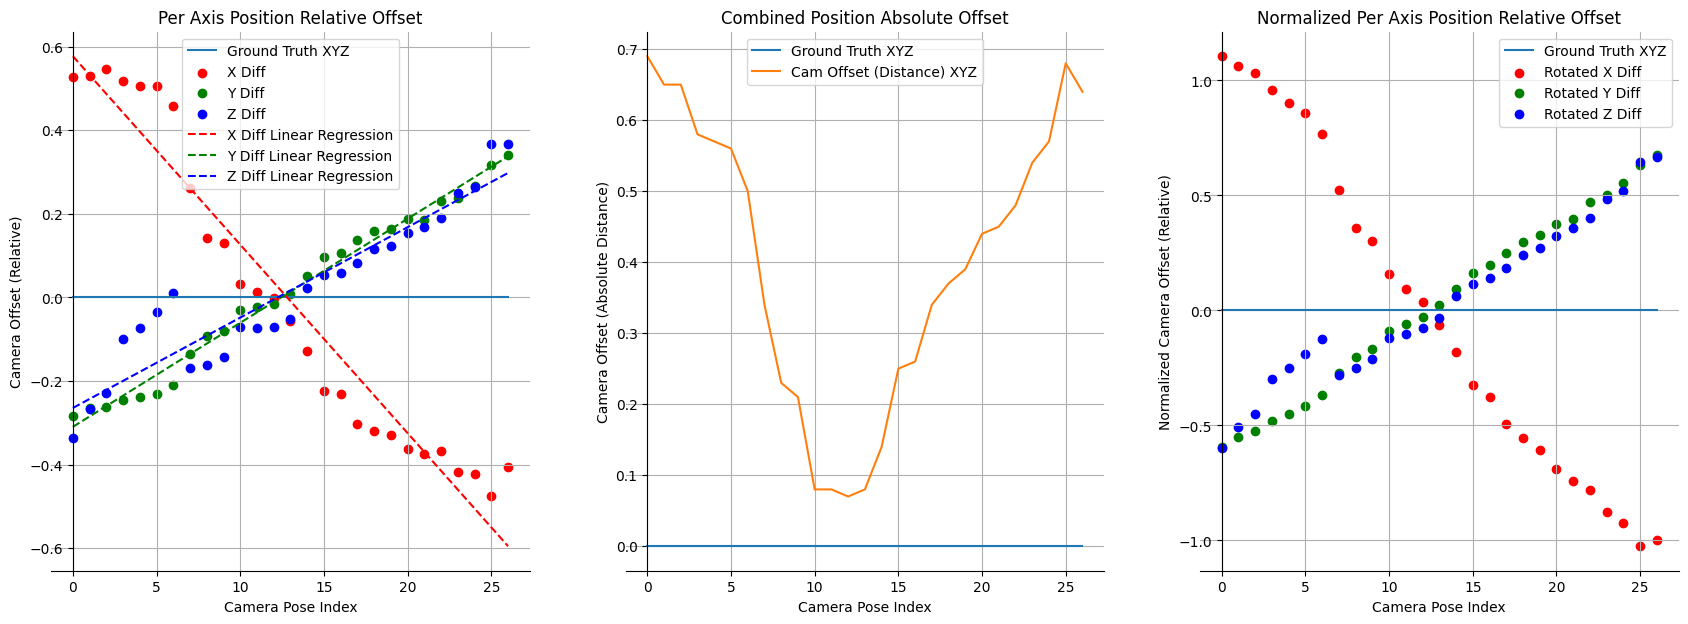

In [112]:
def rotation_matrix(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s], [s, c]])

def generate_cam_offset_plot():
    table, _ = compare_pose_estimation_frames(f"{GROUND_TRUTH_PATH}/transforms_withpoints.json", f"{comparison_path}/transforms_withpoints.json")
    r1_positions = [row[1] for row in table]
    r2_positions = [row[2] for row in table]
    r2_offsets = [row[3] for row in table]
    index_array = np.arange(0, len(r2_positions), 1, dtype=int)
    # axis index x=0, y=1, z=2
    r1_x_axis = np.asarray([p[0] for p in r1_positions])
    r1_y_axis = np.asarray([p[1] for p in r1_positions])
    r1_z_axis = np.asarray([p[2] for p in r1_positions])
    
    r2_x_axis = np.asarray([p[0] for p in r2_positions])
    r2_y_axis = np.asarray([p[1] for p in r2_positions])
    r2_z_axis = np.asarray([p[2] for p in r2_positions])
    
    # Create a figure and axes object
    fig, ax = plt.subplots(1,3) #plt.subplots()

    r2_x_axis_diff = r1_x_axis - r2_x_axis
    r2_y_axis_diff = r1_y_axis - r2_y_axis
    r2_z_axis_diff = r1_z_axis - r2_z_axis

    ### PLOT 1: SEPARATE AXIS ###
    # Plot the ground truth XYZ axis reference
    ax[0].plot(index_array, np.zeros_like(index_array), label='Ground Truth XYZ')
    # Plot the difference for each axis separate
    ax[0].scatter(index_array, r2_x_axis_diff, label='X Diff', color='red')
    ax[0].scatter(index_array, r2_y_axis_diff, label='Y Diff', color='green')
    ax[0].scatter(index_array, r2_z_axis_diff, label='Z Diff', color='blue')

    # Fit a linear regression for each difference axis using numpy.polyfit
    slope_x, intercept_x = np.polyfit(index_array, r2_x_axis_diff,  1)
    slope_y, intercept_y = np.polyfit(index_array, r2_y_axis_diff,  1)
    slope_z, intercept_z = np.polyfit(index_array, r2_z_axis_diff,  1)
    
    # Plot the linear regression lines
    x_fit = np.linspace(index_array.min(), index_array.max(),  100)
    y_fit_x = slope_x * x_fit + intercept_x
    y_fit_y = slope_y * x_fit + intercept_y
    y_fit_z = slope_z * x_fit + intercept_z
    
    ax[0].plot(x_fit, y_fit_x, label='X Diff Linear Regression', color='red', linestyle='--')
    ax[0].plot(x_fit, y_fit_y, label='Y Diff Linear Regression', color='green', linestyle='--')
    ax[0].plot(x_fit, y_fit_z, label='Z Diff Linear Regression', color='blue', linestyle='--')

    # Add labels and legend
    ax[0].set_xlabel('Camera Pose Index')
    ax[0].set_ylabel('Camera Offset (Relative)')
    ax[0].legend()
    ax[0].set_title("Per Axis Position Relative Offset")
    # Grid the plot
    ax[0].grid(True, which='both')
    # Set the position of the left and bottom spines to 'zero'
    ax[0].spines['left'].set_position('zero')
    ax[0].spines['top'].set_position('zero')
    # Turn off the right and top spines
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')

    ### PLOT 2: COMBINED OFFSET ###
    # Plot the ground truth XYZ axis reference
    ax[1].plot(index_array, np.zeros_like(index_array), label='Ground Truth XYZ')
    ax[1].plot(index_array, r2_offsets, label='Cam Offset (Distance) XYZ')

    # Add labels and legend
    ax[1].set_xlabel('Camera Pose Index')
    ax[1].set_ylabel('Camera Offset (Absolute Distance)')
    ax[1].legend()
    ax[1].set_title("Combined Position Absolute Offset")
    # Grid the plot
    ax[1].grid(True, which='both')
    # Set the position of the left and bottom spines to 'zero'
    ax[1].spines['left'].set_position('zero')
    ax[1].spines['top'].set_position('zero')
    # Turn off the right and top spines
    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')

    ### PLOT 3: NORMALIZED SEPARATE AXIS ###
    # Calculate the angle of rotation for each axis using the arctangent of the slope
    angle_x = -np.arctan(slope_x)
    angle_y = -np.arctan(slope_y)
    angle_z = -np.arctan(slope_z)
    
    # Find the intersection point of the linear regression line with the y-axis
    # This will be the rotation origin
    intersection_point_x = (-intercept_x / slope_x), 0
    intersection_point_y = (-intercept_y / slope_y), 0
    intersection_point_z = (-intercept_z / slope_z), 0
    
    # Create a rotation matrix for each axis around the intersection point
    rot_matrix_x = rotation_matrix(angle_x)
    rot_matrix_y = rotation_matrix(angle_y)
    rot_matrix_z = rotation_matrix(angle_z)
    
    # Translate points to the rotation origin
    translated_points_x = np.column_stack((index_array - intersection_point_x[0], r2_x_axis_diff - intersection_point_x[1]))
    translated_points_y = np.column_stack((index_array - intersection_point_y[0], r2_y_axis_diff - intersection_point_y[1]))
    translated_points_z = np.column_stack((index_array - intersection_point_z[0], r2_z_axis_diff - intersection_point_z[1]))

    # Apply the rotation matrix
    rotated_points_x = np.dot(translated_points_x, rot_matrix_x)[:, 1]
    rotated_points_y = np.dot(translated_points_y, rot_matrix_y)[:, 1]
    rotated_points_z = np.dot(translated_points_z, rot_matrix_z)[:, 1]

    # Translate the rotated points back
    rotated_points_x += intersection_point_x[1]
    rotated_points_y += intersection_point_y[1]
    rotated_points_z += intersection_point_z[1]

    # Plot the rotated difference for each axis as points
    ax[2].plot(index_array, np.zeros_like(index_array), label='Ground Truth XYZ')
    ax[2].scatter(index_array, rotated_points_x, label='Rotated X Diff', color='red')
    ax[2].scatter(index_array, rotated_points_y, label='Rotated Y Diff', color='green')
    ax[2].scatter(index_array, rotated_points_z, label='Rotated Z Diff', color='blue')

    # Add labels and legend
    ax[2].set_xlabel('Camera Pose Index')
    ax[2].set_ylabel('Normalized Camera Offset (Relative)')
    ax[2].legend()
    ax[2].set_title("Normalized Per Axis Position Relative Offset")
    # Grid the plot
    ax[2].grid(True, which='both')
    # Set the position of the left and bottom spines to 'zero'
    ax[2].spines['left'].set_position('zero')
    ax[2].spines['top'].set_position('zero')
    # Turn off the right and top spines
    ax[2].spines['right'].set_color('none')
    ax[2].spines['top'].set_color('none')

    # Set the aspect ratio of the plot to be equal
    #ax.set_aspect('equal')
    return fig, ax

cam_off_plt = generate_cam_offset_plot()
plt.rcParams["figure.figsize"] = (21,7)
plt.show()

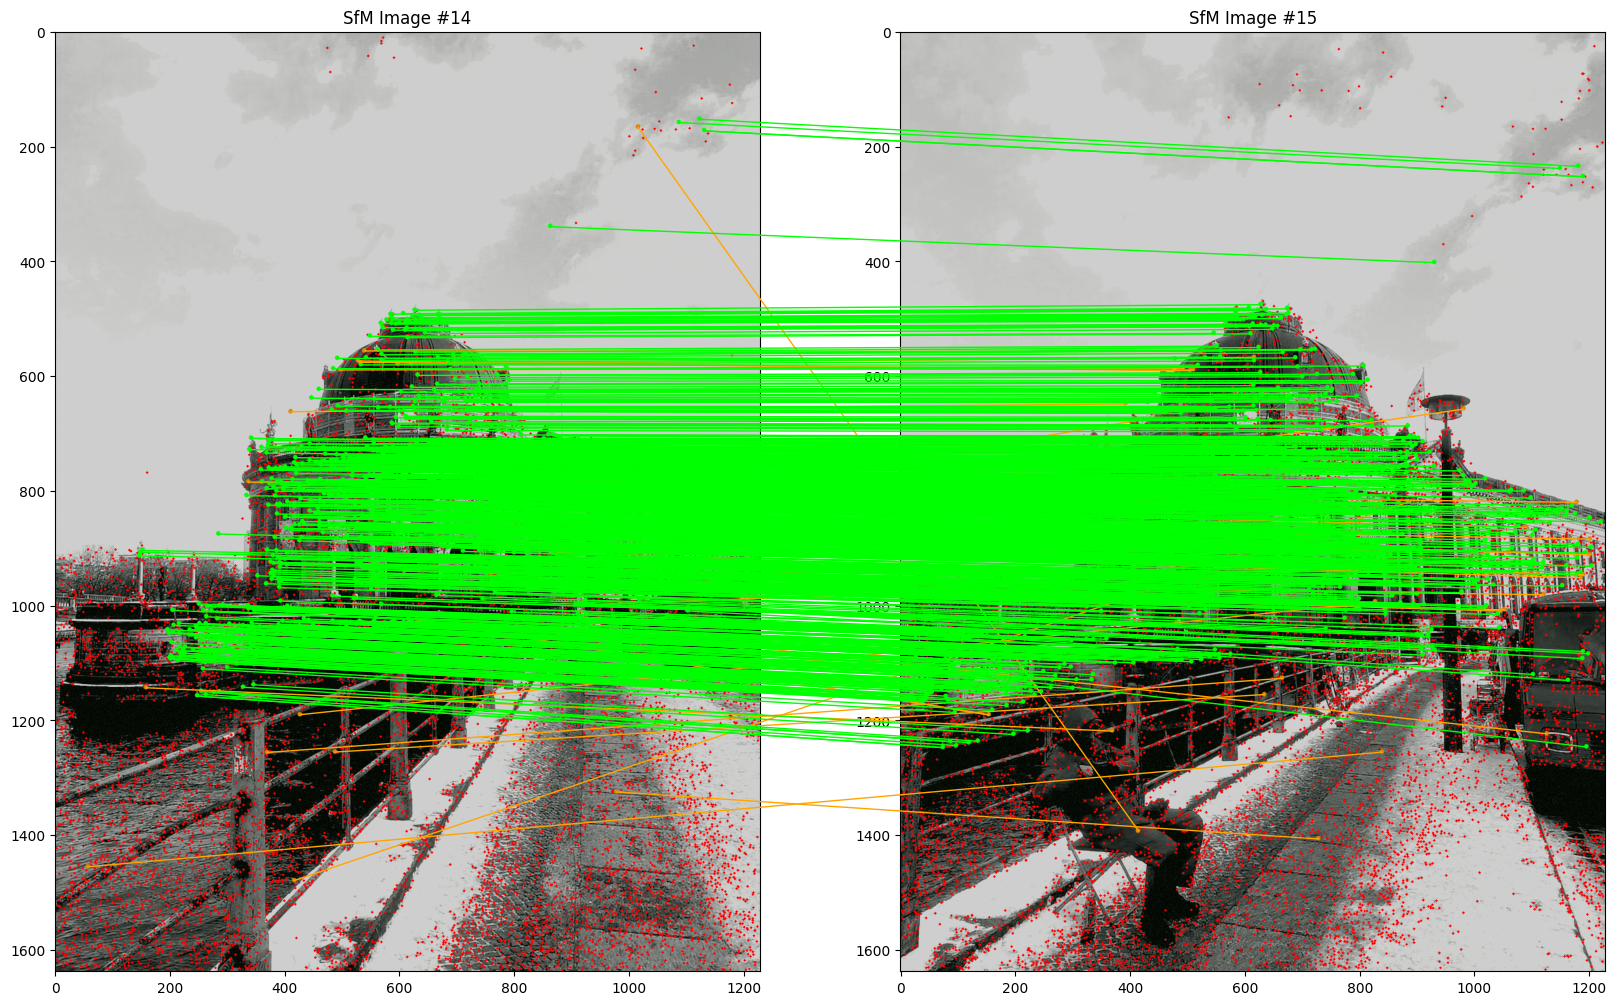

In [110]:
# Display Features for 2 Separate Images
image3_id = image1_id
image4_id = image2_id

# Get the image name and features for the given image ID
image3 = get_image(comparison_cursor, image3_id, comparison_path)
image4 = get_image(comparison_cursor, image4_id, comparison_path)

keypoints3 = get_keypoints(comparison_cursor, image3_id)[0]
for i, kpc in enumerate(keypoints3["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(image3, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

keypoints4 = get_keypoints(comparison_cursor, image4_id)[0]
for i, kpc in enumerate(keypoints4["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(image4, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

outlier_matches_comp = get_outlier_matches(comparison_cursor, [image3_id, image4_id])
inlier_matches_comp = get_inlier_matches(comparison_cursor, [image3_id, image4_id])
if len(outlier_matches_comp) == 0:
    raise Exception("No shared feature matches between both images!")

outlier_matches_comp_coords = get_matches_coords(comparison_cursor, outlier_matches_comp[0])
inlier_matches_comp_coords = get_matches_coords(comparison_cursor, inlier_matches_comp[0])

draw_points(outlier_matches_comp_coords["image_matches"], (0,  133,  219), image3, image4)
draw_points(inlier_matches_comp_coords["image_matches"], (0,  255,  0), image3, image4)

RGB_img3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
RGB_img4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
fig_comp, axarr_comp = plt.subplots(1,2)
axarr_comp[0].imshow(RGB_img3)
axarr_comp[0].set_title(f"SfM Image #{image3_id}")
axarr_comp[1].imshow(RGB_img4)
axarr_comp[1].set_title(f"SfM Image #{image4_id}")

# Loop through each keypoint pair and draw lines
if DISPLAY_CONNECT_LINES:
    draw_lines(outlier_matches_comp_coords["image_matches"], "orange", axarr_comp, fig_comp)
    draw_lines(inlier_matches_comp_coords["image_matches"], "lime", axarr_comp, fig_comp)

plt.show()